# Предсказание стоимости жилья

***Задача:*** В этом проекте нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве.  Для оценки качества модели необходимо использовать метрики RMSE, MAE и R2.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Изучение-пропусков-и-дубликатов" data-toc-modified-id="Изучение-пропусков-и-дубликатов-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Изучение пропусков и дубликатов</a></span></li><li><span><a href="#Исследование-аномалий" data-toc-modified-id="Исследование-аномалий-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Исследование аномалий</a></span><ul class="toc-item"><li><span><a href="#total_rooms" data-toc-modified-id="total_rooms-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>total_rooms</a></span></li><li><span><a href="#population" data-toc-modified-id="population-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>population</a></span></li><li><span><a href="#households" data-toc-modified-id="households-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>households</a></span></li><li><span><a href="#median_income" data-toc-modified-id="median_income-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>median_income</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Подготовка-признаков-к-обучению" data-toc-modified-id="Подготовка-признаков-к-обучению-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка признаков к обучению</a></span><ul class="toc-item"><li><span><a href="#Кодирование-категориальных-признаков" data-toc-modified-id="Кодирование-категориальных-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Кодирование категориальных признаков</a></span></li><li><span><a href="#Трансформация-числовых-признаков" data-toc-modified-id="Трансформация-числовых-признаков-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Трансформация числовых признаков</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Обучение-на-всех-данных" data-toc-modified-id="Обучение-на-всех-данных-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Обучение на всех данных</a></span></li><li><span><a href="#Обучение-только-на-числовых-данных" data-toc-modified-id="Обучение-только-на-числовых-данных-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Обучение только на числовых данных</a></span></li></ul></li><li><span><a href="#Анализ-результатов" data-toc-modified-id="Анализ-результатов-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ результатов</a></span></li></ul></div>

## Обзор данных

In [69]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator
    
RANDOM_SEED = 2022

warnings.filterwarnings('ignore')

In [70]:
# инициализация Spark-сессии
spark = SparkSession.builder \
                    .master('local') \
                    .appName('EDA California Housing') \
                    .getOrCreate() 

spark.sparkContext.setLogLevel("ERROR")

In [71]:
# считывание файла
df_housing = spark.read.load('/datasets/housing.csv', format='csv', sep=',', inferSchema=True, header="true")

In [72]:
# схема датасета
df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [73]:
# первые строки
df_housing.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [74]:
# описательная статистика
df_housing.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


**Документация к данным**:
- `longitude` — широта;
- `latitude` — долгота;
- `housing_median_age` — медианный возраст жителей жилого массива;
- `total_rooms` — общее количество комнат в домах жилого массива;
- `total_bedrooms` — общее количество спален в домах жилого массива;
- `population` — количество человек, которые проживают в жилом массиве;
- `households` — количество домовладений в жилом массиве;
- `median_income` — медианный доход жителей жилого массива;
- `median_house_value` — медианная стоимость дома в жилом массиве;
- `ocean_proximity` — близость к океану.

### Вывод

В датасете 20640 записей о жилых массивах, 10 столбцов.<br>
Один категориальный признак - `ocean_proximity`, означающий удалённость ЖК от океана, остальные признаки числовые.<br>
Есть пропуски в колонке `total_bedrooms`.

## Предобработка данных

### Изучение пропусков и дубликатов

In [75]:
# количество пропусков типа nan
columns = df_housing.columns

for column in columns:
    check_col = F.isnan(F.col(column))
    print(column, df_housing.filter(check_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


In [76]:
# количество пропусков типа null
for column in columns:
    check_col = F.isnull(F.col(column))
    print(column, df_housing.filter(check_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


Обнаружены пропуски в колонке `total_bedrooms`.

In [77]:
# проверяем наличие дубликатов
df_housing.count() - df_housing.dropDuplicates(df_housing.columns).count()

0

Дубликатов не оказалось.

<AxesSubplot:>

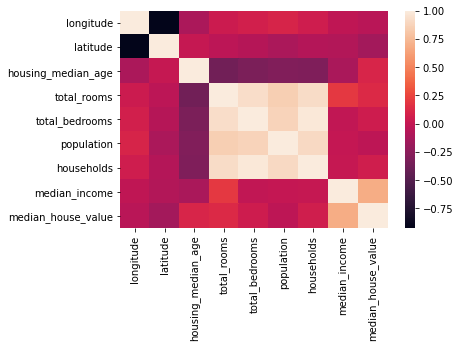

In [78]:
# посмотрим карту корреляции признаков
sns.heatmap(df_housing.toPandas().drop(columns=['ocean_proximity']).corr())

По тепловой карте видно, что признаки `total_rooms` и `total_bedrooms` сильно коррелируют. Поэтому можем удалить признак `total_bedrooms`.

In [79]:
# удаляем признак количества спальных комнат
df_housing = df_housing.drop('total_bedrooms')

### Исследование аномалий

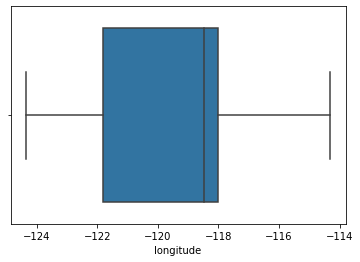

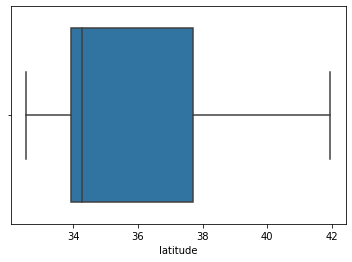

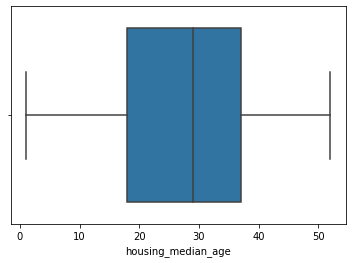

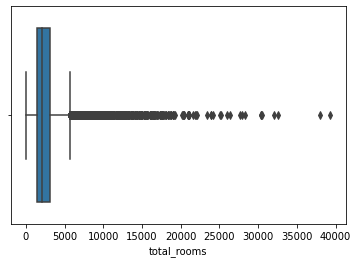

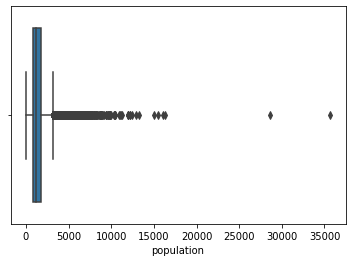

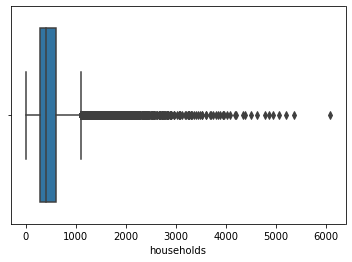

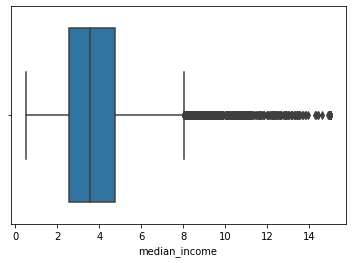

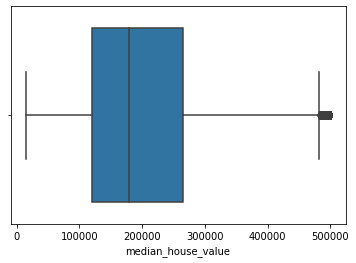

In [80]:
# строим ящики с усами для каждой числовой колонки
for column in df_housing.drop('ocean_proximity').columns:
    sns.boxplot(x=df_housing.toPandas()[column])
    plt.show()

Как видно по графикам, в колонках `total_rooms`, `population`, `households`, `median_income` есть выбросы. Изучим их подробнее.

Чтобы посмотреть потом, какой процент от исходного количества мы удалили, заведём константную переменную с количеством записей в исходном датасете.

In [81]:
# количество записей в исходном датасете
COUNT = 20640

#### total_rooms

In [82]:
# статистика по колонке
df_housing.select('total_rooms').describe().toPandas()

,summary,total_rooms
0,count,20640
1,mean,2635.7630813953488
2,stddev,2181.6152515827944
3,min,2.0
4,max,39320.0


<AxesSubplot:xlabel='total_rooms', ylabel='Count'>

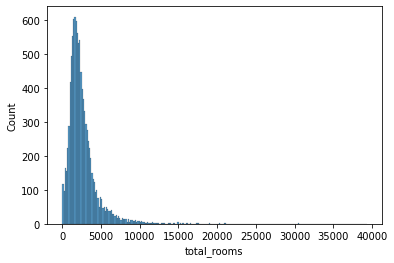

In [83]:
# посмотрим на распределение количества комнат в целом
sns.histplot(data=df_housing.sample(0.5).toPandas(), x='total_rooms')

<AxesSubplot:xlabel='total_rooms', ylabel='Count'>

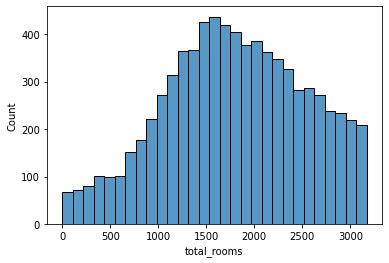

In [84]:
# посмотрим на нижнюю границу распределения
sns.histplot(data=df_housing.sample(0.5).toPandas().query('total_rooms <= total_rooms.quantile(.75)'), x='total_rooms')

<AxesSubplot:xlabel='total_rooms', ylabel='Count'>

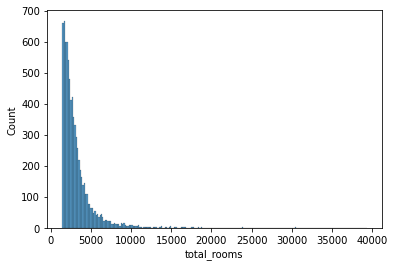

In [85]:
# посмотрим на верхнюю границу распределения
sns.histplot(data=df_housing.sample(0.5).toPandas().query('total_rooms >= total_rooms.quantile(.25)'), x='total_rooms')

Полученные графики и статистики сообщают о том, что в нижней границе нет выбросов, данные сильно скошены именно в сторону верхней границы. Такое большое количество выбросов может помешать модели выявить тенденцию, поэтому проведём границу на отметке .99 квантиля, а остальные выбросы удалим.

In [86]:
# найдём значение .99 квантиля
TOTAL_ROOMS_99 = df_housing.approxQuantile("total_rooms", [0.99], 0)[0]
TOTAL_ROOMS_99

11232.0

In [87]:
# посчитаем процент выбросов, которые собираемся удалить
TOTAL_ROOMS_DELETED = df_housing.filter(df_housing.total_rooms > TOTAL_ROOMS_99).count() / COUNT * 100
TOTAL_ROOMS_DELETED

0.9980620155038761

In [88]:
# удаляем выбросы
df_housing = df_housing.filter(df_housing.total_rooms <= TOTAL_ROOMS_99)

<AxesSubplot:xlabel='total_rooms', ylabel='Count'>

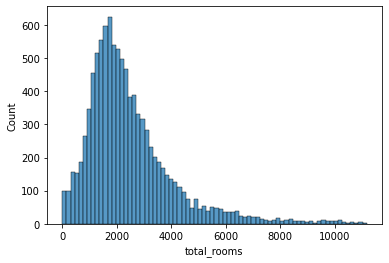

In [89]:
# снова посмотрим на общее распределение количества комнат
sns.histplot(data=df_housing.sample(0.5).toPandas(), x='total_rooms')

Теперь распределение выглядит намного лучше.

#### population

In [90]:
# статистика по колонке
df_housing.select('population').describe().toPandas()

,summary,population
0,count,20434
1,mean,1366.503817167466
2,stddev,907.725659039993
3,min,3.0
4,max,11272.0


<AxesSubplot:xlabel='population', ylabel='Count'>

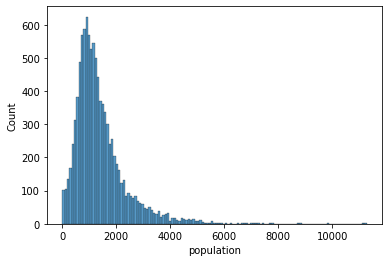

In [91]:
# посмотрим на распределение количества жильцов в целом
sns.histplot(data=df_housing.sample(0.5).toPandas(), x='population')

Наблюдаем ту же ситуацию, что данные скошены в сторону верхней грраницы. Проведём границу на отметке .99 квантиля, а остальные выбросы удалим.

In [92]:
# найдём значение .99 квантиля
POPULATION_99 = df_housing.approxQuantile("population", [0.99], 0)[0]
POPULATION_99

4684.0

In [93]:
# посчитаем процент выбросов к удалению
POPULATION_DELETED = df_housing.filter(df_housing.population > POPULATION_99).count() / COUNT * 100
POPULATION_DELETED

0.9883720930232558

In [94]:
# удаляем выбросы
df_housing = df_housing.filter(df_housing.population <= POPULATION_99) 

<AxesSubplot:xlabel='population', ylabel='Count'>

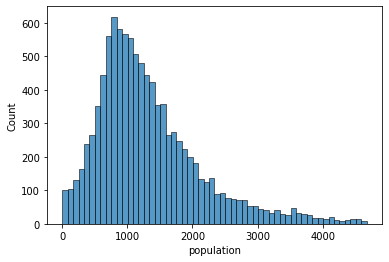

In [95]:
# снова посмотрим на общее распределение количества жильцов
sns.histplot(data=df_housing.sample(0.5).toPandas(), x='population')

Теперь распределение выглядит лучше.

#### households

In [96]:
# статистика по колонке
df_housing.select('households').describe().toPandas()

,summary,households
0,count,20230
1,mean,467.4309441423628
2,stddev,286.89635543455046
3,min,1.0
4,max,2565.0


<AxesSubplot:xlabel='households', ylabel='Count'>

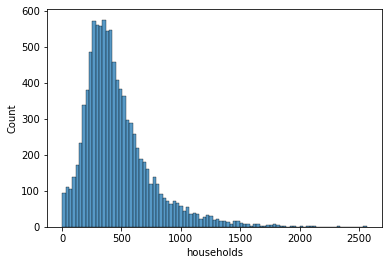

In [97]:
# посмотрим на распределение количества домовладений в целом
sns.histplot(data=df_housing.sample(0.5).toPandas(), x='households')

Как и в предыдущих случаях, данные скошены вправо, но разброс не сильно большой. Также найдём .99 квантиль.

In [98]:
# найдём значение .99 квантиля
HOUSEHOLDS_99 = df_housing.approxQuantile("households", [0.99], 0)[0]
HOUSEHOLDS_99

1474.0

In [99]:
# посчитаем процент выбросов к удалению
HOUSEHOLDS_DELETED = df_housing.filter(df_housing.households > HOUSEHOLDS_99).count() / COUNT * 100
HOUSEHOLDS_DELETED

0.9738372093023256

In [100]:
# удаляем выбросы
df_housing = df_housing.filter(df_housing.households <= HOUSEHOLDS_99) 

<AxesSubplot:xlabel='households', ylabel='Count'>

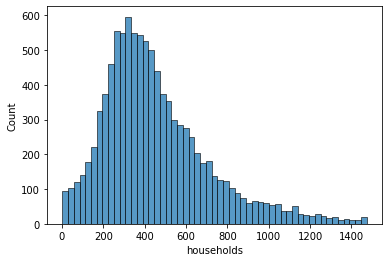

In [101]:
# снова посмотрим на общее распределение количества жильцов
sns.histplot(data=df_housing.sample(0.5).toPandas(), x='households')

Теперь распределение выглядит лучше.

<div class="alert alert-block alert-info">
<b>Комментарий студента V2:</b> Добавила ко всем колонкам удаление по .99 квантилю, чтбы всё по науке было
</div>

#### median_income

In [102]:
# статистика по колонке
df_housing.select('median_income').describe().toPandas()

,summary,median_income
0,count,20029
1,mean,3.863432867342394
2,stddev,1.9065573932749351
3,min,0.4999
4,max,15.0001


<AxesSubplot:xlabel='median_income', ylabel='Count'>

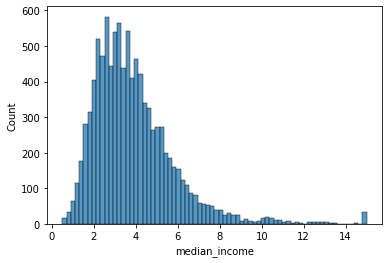

In [103]:
# посмотрим на распределение медианного дохода жителей в целом
sns.histplot(data=df_housing.sample(0.5).toPandas(), x='median_income')

Как обычно, данные скошены вправо, ищем .99 квантиль.

In [104]:
# найдём значение .99 квантиля
MEDIAN_INCOME_99 = df_housing.approxQuantile("median_income", [0.99], 0)[0]
MEDIAN_INCOME_99

10.6514

In [105]:
# посчитаем процент выбросов к удалению
MEDIAN_INCOME_DELETED = df_housing.filter(df_housing.median_income > MEDIAN_INCOME_99).count() / COUNT * 100
MEDIAN_INCOME_DELETED

0.9689922480620154

In [106]:
# удаляем выбросы
df_housing = df_housing.filter(df_housing.median_income <= MEDIAN_INCOME_99) 

<AxesSubplot:xlabel='median_income', ylabel='Count'>

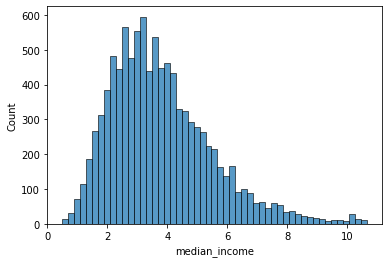

In [107]:
# снова посмотрим на общее распределение количества жильцов
sns.histplot(data=df_housing.sample(0.5).toPandas(), x='median_income')

Теперь распределение выглядит лучше.

In [108]:
# посчитаем общий процент удалённых записей
DELETED = TOTAL_ROOMS_DELETED + POPULATION_DELETED + HOUSEHOLDS_DELETED + MEDIAN_INCOME_DELETED
DELETED

3.929263565891473

Итого, удалённых данных почти 5%.

### Вывод

В этом разделе:
- Удалены почти 5% выбросов из колонок `total_rooms`, `total_bedrooms`, `households`, `median_income` и `population`
- Пропусков и дубликатов нет
- Удалили признак `total_bedrooms`из-за высокой корреляции с признаком `total_rooms`

## Подготовка признаков к обучению

### Кодирование категориальных признаков

In [109]:
# разобьём данные на обучающую и тестовую выборки
train_data, test_data = df_housing.randomSplit([.8,.2], seed=RANDOM_SEED)
print(train_data.count(), test_data.count())

15770 4059


Разделим признаки на категориальные, числовые и целевой.

In [110]:
categorical_cols = ["ocean_proximity"]
numerical_cols  = ["longitude", "latitude", "housing_median_age", "total_rooms", "population", "households", "median_income"]
target = "median_house_value"

В первую очередь трансформируем категориальные признаки с помощью трансформера StringIndexer. Он переводит текстовые категории в числовое представление, так как большинство ML-алгоритмов работает с числовыми данными. В данных только один категориальный признак - это `ocean_proximity`.

In [111]:
indexer = StringIndexer(inputCols=categorical_cols, 
                        outputCols=[c+'_idx' for c in categorical_cols])

Далее закодируем его техникой OneHotEncoding.

In [112]:
encoder = OneHotEncoder(inputCols=['ocean_proximity_idx'],
                        outputCols=['ocean_proximity_ohe'])

### Трансформация числовых признаков

Приведём числовые признаки к одному масштабу, т.к. линейные модели чувствительны к масштабу.

In [113]:
numerical_assembler = VectorAssembler(inputCols=numerical_cols,
                                    outputCol="numerical_features")

In [114]:
standardScaler = StandardScaler(inputCol='numerical_features',
                                outputCol="numerical_features_scaled")

Финальный шаг преобразований — это объединение признаков в один вектор, с которым ML-алгоритм умеет работать.

In [115]:
all_features = ['ocean_proximity_ohe','numerical_features_scaled']

final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol="features") 

## Обучение моделей

In [116]:
# создаём функцию для обучения модели
def train_model(features):
    
    # создаём объект модели линейной регрессии
    lr = LinearRegression(labelCol=target, featuresCol=features)
    
    # строим сетку для подбора гиперпараметров
    grid_search = ParamGridBuilder() \
        .addGrid(lr.regParam, [0.0, 0.01, 0.1]) \
        .addGrid(lr.elasticNetParam, [0.5, 1.0]) \
        .build()
    
    # создаём объект для оценки качества модели метрикой RMSE
    evaluator = RegressionEvaluator(predictionCol='prediction',
                                    labelCol=target)
    
    # строим итоговый пайплайн для обучения модели
    pipeline = Pipeline(
        stages = [indexer, 
                  encoder, 
                  numerical_assembler, 
                  standardScaler, 
                  final_assembler,
                  lr]
    )
    
    # создаём кросс-валидатор
    cv = CrossValidator(estimator=pipeline,
                        estimatorParamMaps=grid_search,
                        evaluator=evaluator,
                        numFolds = 5)
    
    # обучаем кросс-валидатор на обучающей выборке
    cv_model = cv.fit(train_data)
    
    # получаем лучшую модель
    best_model = cv_model.bestModel
    
    # получаем параметры лучшей модели
    params = best_model.stages[5].extractParamMap()
    
    # получаем предсказания на тестовой выборке
    predictions = best_model.transform(test_data)
    
    return params, predictions

### Обучение на всех данных

In [117]:
# обучаем модель на полном наборе данных
params_on_full, predictions_on_full = train_model('features')

In [118]:
predictions_on_full.select('median_house_value', 'prediction').sample(0.5).toPandas().head(10)

,median_house_value,prediction
0,50800.0,209070.320509
1,67000.0,144711.197177
2,81300.0,148460.392448
3,60000.0,138340.645039
4,109400.0,167549.205143
5,74100.0,147878.816700
6,74700.0,171737.805867
7,74100.0,156433.467237
8,67500.0,143002.784200
9,92500.0,168593.206176


In [119]:
predictions_on_full.select('median_house_value', 'prediction').sample(0.5).toPandas().tail(10)

,median_house_value,prediction
2103,53800.0,19197.216114
2104,67500.0,51099.244465
2105,87500.0,149276.031029
2106,76200.0,121108.832906
2107,60800.0,57760.734400
2108,53400.0,38461.437447
2109,67500.0,50766.249308
2110,74300.0,68541.252449
2111,44000.0,15456.088694
2112,25000.0,-10054.158048


In [120]:
rmse_on_full = RegressionEvaluator(labelCol='median_house_value', metricName='rmse').evaluate(predictions_on_full)
r2_on_full = RegressionEvaluator(labelCol='median_house_value', metricName='r2').evaluate(predictions_on_full)
mae_on_full = RegressionEvaluator(labelCol='median_house_value', metricName='mae').evaluate(predictions_on_full)

In [121]:
print("RMSE на полном наборе данных:", rmse_on_full)

RMSE на полном наборе данных: 67743.10668969016


In [122]:
print("MAE на полном наборе данных:", mae_on_full)

MAE на полном наборе данных: 48929.61618482056


In [123]:
print("R2 на полном наборе данных:", r2_on_full)

R2 на полном наборе данных: 0.643058091392138


Видно, что в некоторых случаях модель предсказала отрицаткльный результат. Посмотрим, сколько таких значений получилось.

In [124]:
predictions_on_full.filter(F.col('prediction') < 0).count()

12

In [130]:
predictions_on_full.filter(F.col('prediction') < 0).toPandas()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_idx,ocean_proximity_ohe,numerical_features,numerical_features_scaled,features,prediction
0,-124.15,41.81,17.0,3276.0,3546.0,585.0,2.2868,103100.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0)","[-124.15, 41.81, 17.0, 3276.0, 3546.0, 585.0, ...","[-61.79738142534058, 19.48199010055772, 1.3652...","[0.0, 0.0, 1.0, 0.0, -61.79738142534058, 19.48...",-9320.579842
1,-121.79,38.54,7.0,1777.0,4479.0,504.0,1.4653,310000.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-121.79, 38.54, 7.0, 1777.0, 4479.0, 504.0, 1...","[-60.622658749836724, 17.95828506279585, 0.562...","[0.0, 1.0, 0.0, 0.0, -60.622658749836724, 17.9...",-148822.837160
2,-120.51,40.41,36.0,36.0,4198.0,7.0,5.5179,67500.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-120.51, 40.41, 36.0, 36.0, 4198.0, 7.0, 5.5179]","[-59.98552102752954, 18.82963931986456, 2.8911...","[0.0, 1.0, 0.0, 0.0, -59.98552102752954, 18.82...",-114008.063171
3,-120.09,39.92,19.0,2335.0,1028.0,383.0,1.7267,60700.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-120.09, 39.92, 19.0, 2335.0, 1028.0, 383.0, ...","[-59.7764602123975, 18.601316546621963, 1.5258...","[0.0, 1.0, 0.0, 0.0, -59.7764602123975, 18.601...",-4405.362463
4,-120.08,41.79,34.0,1355.0,434.0,178.0,2.0903,56100.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-120.08, 41.79, 34.0, 1355.0, 434.0, 178.0, 2...","[-59.771482573941974, 19.472670803690676, 2.73...","[0.0, 1.0, 0.0, 0.0, -59.771482573941974, 19.4...",-21247.792849
5,-120.06,39.15,22.0,2213.0,98.0,42.0,1.1912,170000.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-120.06, 39.15, 22.0, 2213.0, 98.0, 42.0, 1.1...","[-59.76152729703093, 18.242523617240725, 1.766...","[0.0, 1.0, 0.0, 0.0, -59.76152729703093, 18.24...",-21182.882867
6,-119.75,36.72,22.0,3247.0,4179.0,881.0,1.3343,60800.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-119.75, 36.72, 22.0, 3247.0, 4179.0, 881.0, ...","[-59.607220504909655, 17.110229047894748, 1.76...","[0.0, 1.0, 0.0, 0.0, -59.607220504909655, 17.1...",-46015.725993
7,-119.28,36.33,10.0,1051.0,927.0,274.0,0.7800,55500.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-119.28, 36.33, 10.0, 1051.0, 927.0, 274.0, 0...","[-59.37327149749999, 16.92850275898737, 0.8030...","[0.0, 1.0, 0.0, 0.0, -59.37327149749999, 16.92...",-390.229504
8,-114.68,33.49,20.0,1491.0,1135.0,303.0,1.6395,44400.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-114.68, 33.49, 20.0, 1491.0, 1135.0, 303.0, ...","[-57.08355780795858, 15.60516260386697, 1.6061...","[0.0, 1.0, 0.0, 0.0, -57.08355780795858, 15.60...",-8480.643708
9,-114.65,32.79,21.0,44.0,64.0,27.0,0.8571,25000.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-114.65, 32.79, 21.0, 44.0, 64.0, 27.0, 0.8571]","[-57.068624892592005, 15.278987213520393, 1.68...","[0.0, 1.0, 0.0, 0.0, -57.068624892592005, 15.2...",-10054.158048


Отрицательных предсказаний получилось совсем немного. Если посмотреть на выборку, то можно заметить, что у этих записей возраст здания небольшой, медианный доход на жителя ниже среднего, и почти все удалены от океана. Может быть, совокупность этих признаков даёт такой результат модели. Некоторые записи вообще выглядят странно, например, где 7 домовладений, но при этом 4198 человек население. Такие записи явно аномальны, поэтому модель не смогла адекватно их оценить.

### Обучение только на числовых данных

In [125]:
# обучаем модель только на числовых данных
params_on_num, predictions_on_num = train_model('numerical_features_scaled')

In [57]:
predictions_on_num.select('median_house_value', 'prediction').sample(0.5).toPandas().head(10)

,median_house_value,prediction
0,103600.0,99561.784205
1,68400.0,74319.508140
2,72200.0,130245.968891
3,81300.0,117097.005807
4,70500.0,136324.294133
5,90000.0,183763.493365
6,104200.0,170115.994782
7,74100.0,125860.652331
8,67500.0,111915.548272
9,92500.0,143084.443367


In [58]:
predictions_on_num.select('median_house_value', 'prediction').sample(0.5).toPandas().tail(10)

,median_house_value,prediction
2067,76200.0,132935.813815
2068,61000.0,68696.920631
2069,60800.0,62222.960366
2070,91200.0,64000.644499
2071,107800.0,115085.435021
2072,67500.0,57988.842451
2073,74300.0,75298.258574
2074,44000.0,11744.801852
2075,65500.0,4406.253770
2076,66900.0,-55085.359467


In [59]:
rmse_on_num = RegressionEvaluator(labelCol='median_house_value', metricName='rmse').evaluate(predictions_on_num)
r2_on_num = RegressionEvaluator(labelCol='median_house_value', metricName='r2').evaluate(predictions_on_num)
mae_on_num = RegressionEvaluator(labelCol='median_house_value', metricName='mae').evaluate(predictions_on_num)

In [60]:
print("RMSE на числовых данных:", rmse_on_num)

RMSE на числовых данных: 68591.95895568973


In [61]:
print("MAE на числовых данных:", mae_on_num)

MAE на числовых данных: 49972.23760294756


In [62]:
print("R2 на числовых данных:", r2_on_num)

R2 на числовых данных: 0.6340567547019039


In [126]:
predictions_on_num.filter(F.col('prediction') < 0).count()

24

In [128]:
predictions_on_num.filter(F.col('prediction') < 0).toPandas()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_idx,ocean_proximity_ohe,numerical_features,numerical_features_scaled,features,prediction
0,-124.15,41.81,17.0,3276.0,3546.0,585.0,2.2868,103100.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0)","[-124.15, 41.81, 17.0, 3276.0, 3546.0, 585.0, ...","[-61.79738142534058, 19.48199010055772, 1.3652...","[0.0, 0.0, 1.0, 0.0, -61.79738142534058, 19.48...",-61584.556165
1,-122.26,37.87,52.0,1087.0,3337.0,350.0,1.4012,175000.0,NEAR BAY,3.0,"(0.0, 0.0, 0.0, 1.0)","[-122.26, 37.87, 52.0, 1087.0, 3337.0, 350.0, ...","[-60.85660775724639, 17.64608861774984, 4.1760...","[0.0, 0.0, 0.0, 1.0, -60.85660775724639, 17.64...",-3633.638449
2,-122.26,41.66,17.0,1885.0,953.0,328.0,2.1607,61400.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-122.26, 41.66, 17.0, 1885.0, 953.0, 328.0, 2...","[-60.85660775724639, 19.41209537405488, 1.3652...","[0.0, 1.0, 0.0, 0.0, -60.85660775724639, 19.41...",-17087.324788
3,-121.93,41.86,28.0,4225.0,1908.0,686.0,1.7400,44000.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-121.93, 41.86, 28.0, 4225.0, 1908.0, 686.0, ...","[-60.69234568821407, 19.505288342725333, 2.248...","[0.0, 1.0, 0.0, 0.0, -60.69234568821407, 19.50...",-34298.707126
4,-121.79,38.54,7.0,1777.0,4479.0,504.0,1.4653,310000.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-121.79, 38.54, 7.0, 1777.0, 4479.0, 504.0, 1...","[-60.622658749836724, 17.95828506279585, 0.562...","[0.0, 1.0, 0.0, 0.0, -60.622658749836724, 17.9...",-142711.015892
5,-121.67,40.61,8.0,2411.0,786.0,297.0,2.1513,80400.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-121.67, 40.61, 8.0, 2411.0, 786.0, 297.0, 2....","[-60.56292708837042, 18.922832288535016, 0.642...","[0.0, 1.0, 0.0, 0.0, -60.56292708837042, 18.92...",-8971.625520
6,-121.11,41.07,26.0,1707.0,761.0,250.0,2.7188,48100.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-121.11, 41.07, 26.0, 1707.0, 761.0, 250.0, 2...","[-60.28417933486103, 19.137176116477054, 2.088...","[0.0, 1.0, 0.0, 0.0, -60.28417933486103, 19.13...",-9853.729517
7,-120.96,41.12,29.0,779.0,364.0,123.0,2.5000,59200.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-120.96, 41.12, 29.0, 779.0, 364.0, 123.0, 2.5]","[-60.209514758028156, 19.160474358644663, 2.32...","[0.0, 1.0, 0.0, 0.0, -60.209514758028156, 19.1...",-21943.563797
8,-120.74,39.39,18.0,453.0,152.0,77.0,1.3523,85700.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-120.74, 39.39, 18.0, 453.0, 152.0, 77.0, 1.3...","[-60.10000671200661, 18.354355179645268, 1.445...","[0.0, 1.0, 0.0, 0.0, -60.10000671200661, 18.35...",-17520.185312
9,-120.51,40.41,36.0,36.0,4198.0,7.0,5.5179,67500.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-120.51, 40.41, 36.0, 36.0, 4198.0, 7.0, 5.5179]","[-59.98552102752954, 18.82963931986456, 2.8911...","[0.0, 1.0, 0.0, 0.0, -59.98552102752954, 18.82...",-154093.561627


Здесь ситуация с отрицательными значениями обстоит так же, как и с результатами на полном наборе данных: закономерности те же, самих отрицательных значений немного, хоть и больше, чем в первом случае.

In [63]:
spark.stop()

## Анализ результатов

Все три метрики - RMSE, MAE и R2 - показали, что модель показывает лучшее качество на данных, включающих в себя категориальный признак, чем только на числовых данных.<br>

**RMSE:** 67743<br>
**MAE:** 48929<br>
**R2:** 0.643<br>